In [4]:
import pandas as pd 

In [5]:
# Read and reshape the NetLogo BehaviorSpace CSV for analysis

# Path to the CSV file
csv_path = "/Users/erick/Desktop/Model bus-capacity-effect-spreadsheet.csv"

# Skip the first 26 lines (metadata and parameters)
df_raw = pd.read_csv(csv_path, skiprows=26)

# The first column is empty, drop it
df_raw = df_raw.drop(df_raw.columns[0], axis=1)

# There are 30 experiments, each with two columns: step and saved
num_experiments = 30
experiments = []

# The bus-capacity changes every 10 experiments: 20, 40, 80
bus_capacities = [20]*10 + [40]*10 + [80]*10

for i in range(num_experiments):
    step_col = i*2
    saved_col = i*2 + 1
    exp_df = pd.DataFrame({
        "experiment": i+1,
        "bus_capacity": bus_capacities[i],
        "step": df_raw.iloc[:, step_col],
        "saved": df_raw.iloc[:, saved_col]
    })
    experiments.append(exp_df)

# Combine all experiments into a single DataFrame
df = pd.concat(experiments, ignore_index=True)

df.head()

,experiment,bus_capacity,step,saved
0,1,20,0,0
1,1,20,1,0
2,1,20,2,0
3,1,20,3,0
4,1,20,4,0


In [6]:
df.shape

(135030, 4)

In [8]:
135030/4501

30.0

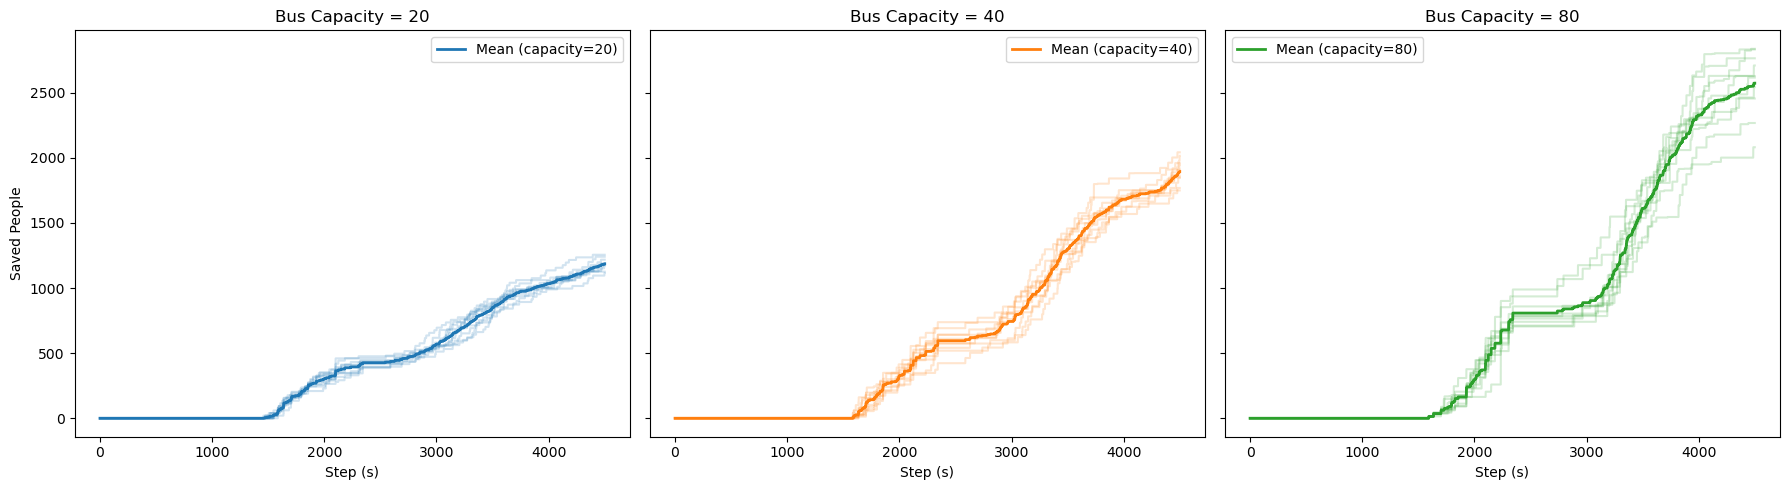

In [11]:
# Plot all experiments and their mean for each bus capacity
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with three panels
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
bus_caps = [20, 40, 80]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (cap, ax) in enumerate(zip(bus_caps, axes)):
    # Filter experiments for this bus capacity
    df_cap = df[df['bus_capacity'] == cap]
    # Plot all experiments in light color
    for exp in df_cap['experiment'].unique():
        exp_data = df_cap[df_cap['experiment'] == exp]
        ax.plot(exp_data['step'], exp_data['saved'], color=colors[idx], alpha=0.2)
    # Plot the mean in strong color
    mean_data = df_cap.groupby('step')['saved'].mean().reset_index()
    ax.plot(mean_data['step'], mean_data['saved'], color=colors[idx], linewidth=2, label=f"Mean (capacity={cap})")
    ax.set_title(f"Bus Capacity = {cap}")
    ax.set_xlabel("Step (s)")
    if idx == 0:
        ax.set_ylabel("Saved People")
    ax.legend()
plt.tight_layout()
plt.show()

/var/folders/w1/25w7xf2533n3rqqn8t50qvnh0000gn/T/ipykernel_59936/2405928319.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_means = df.groupby('bus_capacity').apply(lambda d: d.groupby('step')['saved'].mean().max())


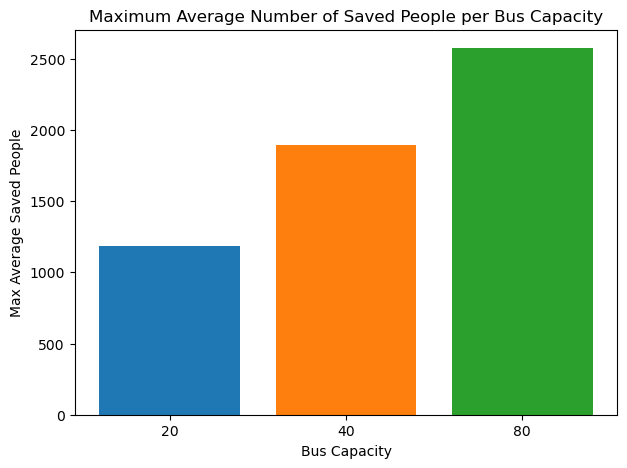

In [12]:
# Plot the maximum average number of saved people for each bus-capacity as a bar chart

# Compute the mean saved people per step for each bus capacity
max_means = df.groupby('bus_capacity').apply(lambda d: d.groupby('step')['saved'].mean().max())

plt.figure(figsize=(7,5))
plt.bar(max_means.index.astype(str), max_means.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Bus Capacity')
plt.ylabel('Max Average Saved People')
plt.title('Maximum Average Number of Saved People per Bus Capacity')
plt.show()

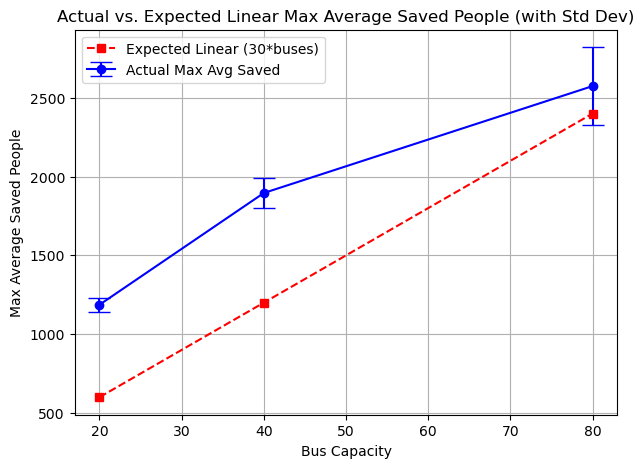

In [16]:
import numpy as np

# Compare actual vs. expected linear increments in max average saved people, including std deviation error bars

# Actual data from previous calculation
actual_max = max_means.values
bus_caps = max_means.index.values

# Calculate standard deviation of the max average saved people for each bus-capacity group
stds = []
for cap in bus_caps:
    df_cap = df[df['bus_capacity'] == cap]
    # For each experiment, get the max saved value (per run)
    max_per_exp = df_cap.groupby('experiment')['saved'].max()
    stds.append(max_per_exp.std())
stds = np.array(stds)

# Expected linear increments (assuming max saved = 30 * bus_capacity)
expected_max = 30 * bus_caps

plt.figure(figsize=(7,5))
plt.errorbar(bus_caps, actual_max, yerr=stds, fmt='o-', label='Actual Max Avg Saved', color='blue', capsize=8)
plt.plot(bus_caps, expected_max, 's--', label='Expected Linear (30*buses)', color='red')
plt.xlabel('Bus Capacity')
plt.ylabel('Max Average Saved People')
plt.title('Actual vs. Expected Linear Max Average Saved People (with Std Dev)')
plt.legend()
plt.grid(True)
plt.show()

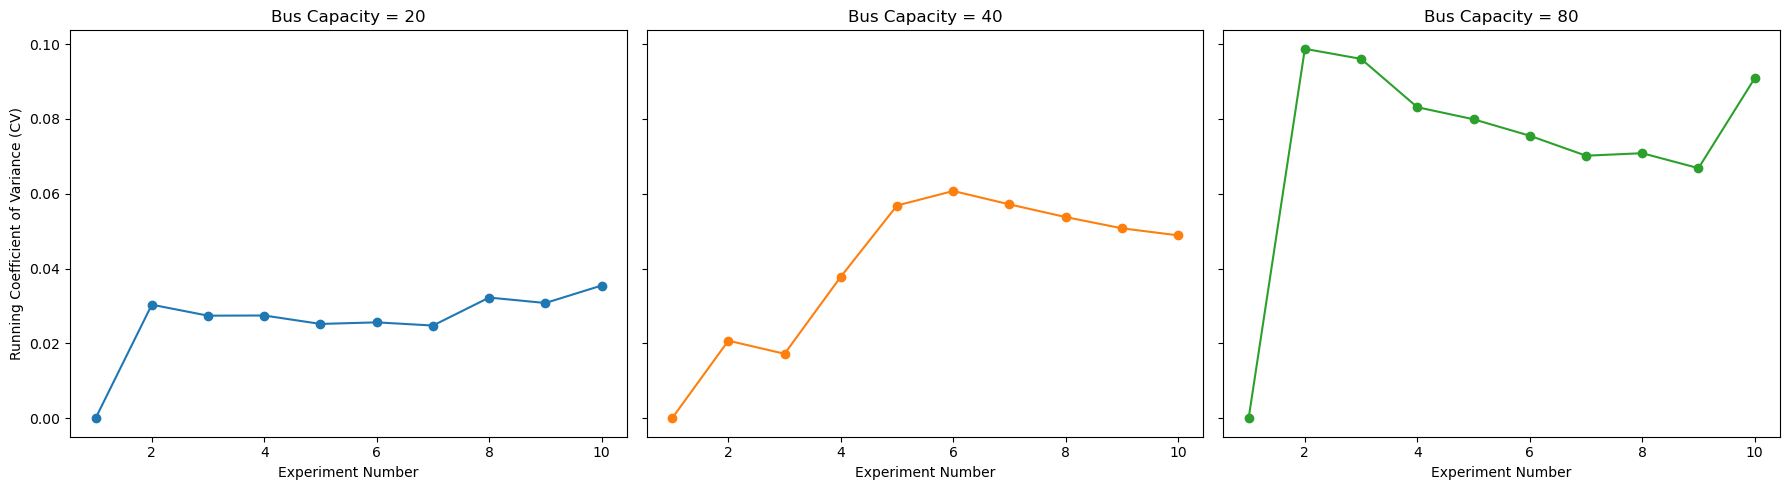

In [19]:
# Plot the running coefficient of variance (CV) for the max evacuated people per experiment

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
bus_caps = [20, 40, 80]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (cap, ax) in enumerate(zip(bus_caps, axes)):
    df_cap = df[df['bus_capacity'] == cap]
    # For each experiment, get the max saved value (last point)
    max_per_exp = df_cap.groupby('experiment')['saved'].max().sort_index()
    # Calculate running CV
    running_cv = [np.std(max_per_exp.values[:i+1]) / np.mean(max_per_exp.values[:i+1]) if i > 0 else 0 for i in range(len(max_per_exp))]
    ax.plot(range(1, len(max_per_exp)+1), running_cv, color=colors[idx], marker='o')
    ax.set_title(f'Bus Capacity = {cap}')
    ax.set_xlabel('Experiment Number')
    if idx == 0:
        ax.set_ylabel('Running Coefficient of Variance (CV)')
    # ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()


## Interpretation of Simulation Results

The running coefficient of variance (CV) plot for each bus capacity case provides insight into the variability and stability of the evacuation outcomes across repeated experiments:

- **CV Trend**: For each bus capacity, the CV starts higher and generally decreases as more experiments are included, indicating that the results become more stable and less variable with more runs. If the CV remains high or fluctuates, it suggests persistent variability in the outcomes.
- **Comparison Across Capacities**: If higher bus capacities (e.g., 80) show lower CVs than lower capacities (e.g., 20), it means that increasing bus capacity not only increases the number of people evacuated but also makes the results more consistent. If the CVs are similar, then increasing capacity does not reduce variability.
- **Absolute CV Values**: A low CV (e.g., <0.05) means the simulation is highly repeatable and robust to random variation. A high CV (e.g., >0.1) suggests that stochastic effects or model sensitivity are significant.

### What Can Be Improved?
- **Reduce Variability**: If CVs are high, consider increasing the number of experiments to better estimate the mean and reduce uncertainty. Also, review model parameters that may introduce excessive randomness.
- **Model Robustness**: If the mean number of saved people does not scale linearly with bus capacity, investigate bottlenecks in the evacuation process (e.g., road congestion, loading times, or other constraints not related to bus capacity).
- **Experiment Design**: Ensure that all other parameters are controlled and only bus capacity is varied. If other parameters are changing, it may confound the results.
- **Further Analysis**: Analyze the distribution of maximum saved people per experiment for outliers or multimodal behavior, which may indicate hidden model dynamics or rare events.

### Summary
- The CV plots help you assess the reliability of your simulation results.
- Lower CVs and linear scaling with bus capacity are desirable for predictable evacuation planning.
- Use these diagnostics to refine your model and experiment setup for more robust and interpretable results.


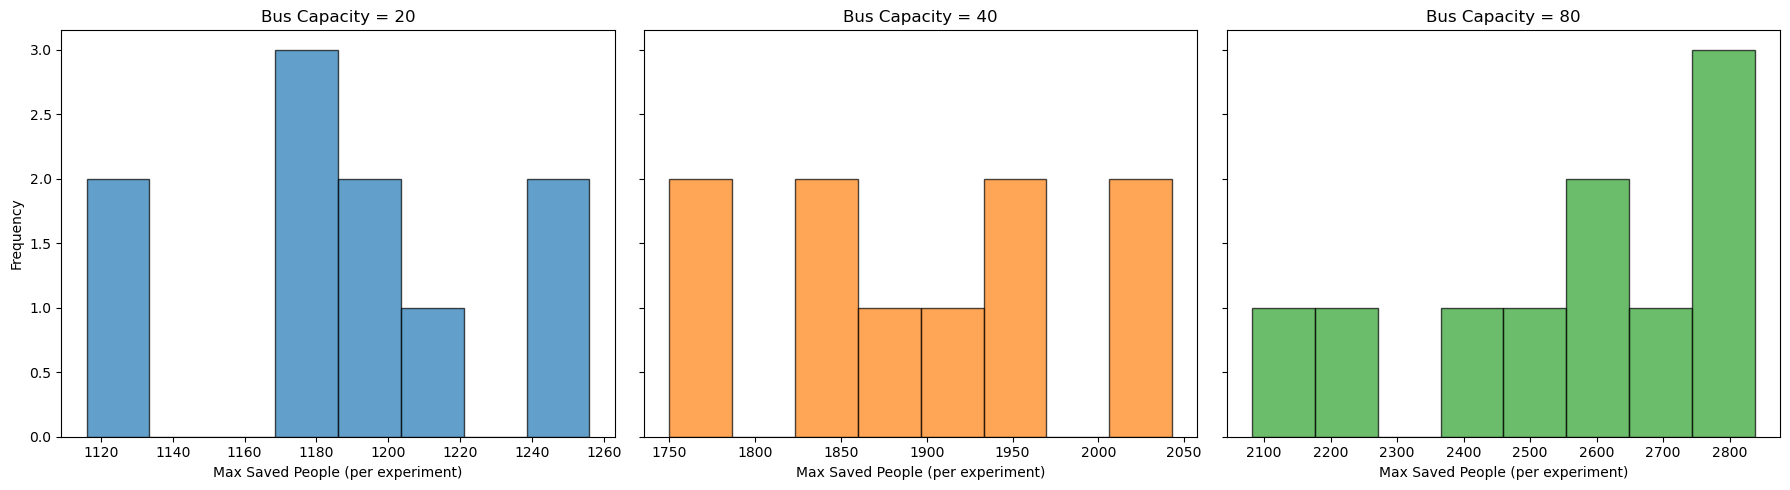

In [21]:
# Plot histograms of max saved people per experiment for each bus capacity
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
bus_caps = [20, 40, 80]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (cap, ax) in enumerate(zip(bus_caps, axes)):
    df_cap = df[df['bus_capacity'] == cap]
    max_per_exp = df_cap.groupby('experiment')['saved'].max()
    ax.hist(max_per_exp, bins=8, color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_title(f'Bus Capacity = {cap}')
    ax.set_xlabel('Max Saved People (per experiment)')
    if idx == 0:
        ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Certainly! Here’s how to interpret the histogram plots of the maximum saved people per experiment for each bus capacity:

---

### **Interpretation of Histograms**

#### **1. Multimodal Distributions**
- **What to Look For:**  
  A multimodal distribution will show two or more distinct peaks (modes) in the histogram.
- **What It Means:**  
  - **Multiple Peaks:** If you see more than one peak, it suggests that there are different "types" of outcomes occurring in your simulation. For example, some runs might result in high evacuation (perhaps when buses avoid congestion), while others result in much lower evacuation (perhaps due to traffic jams or delays).
  - **Implication:** This could indicate that your model has underlying dynamics or rare events that cause the system to behave very differently under certain conditions. It may also suggest sensitivity to initial conditions or random events.

#### **2. Skewness**
- **What to Look For:**  
  Skewness refers to the asymmetry of the distribution:
  - **Right-skewed (long tail to the right):** Most experiments have lower saved numbers, but a few have much higher.
  - **Left-skewed (long tail to the left):** Most experiments have higher saved numbers, but a few have much lower.
- **What It Means:**  
  - **Right-skewed:** Indicates that while most runs are less successful, occasionally the system performs much better—perhaps due to lucky circumstances or rare avoidance of bottlenecks.
  - **Left-skewed:** Indicates that most runs are successful, but occasionally something goes wrong (e.g., a major jam or failure), leading to poor outcomes.
  - **Symmetric:** Most runs are similar, and the system is robust and predictable.

---

### **What Does This Mean for Your Simulation?**

- **Multimodality** suggests your model may have critical thresholds or tipping points (e.g., if a bus gets stuck, many people are left behind; if not, most are saved). Investigate what causes runs to fall into different modes.
- **Skewness** indicates whether your system is prone to occasional failures or successes. If you see strong skewness, look for rare events or model features that could be causing these outliers.

---

### **What Should You Do?**

- **If Multimodal:**  
  - Investigate the causes of different modes (e.g., random seed, initial conditions, specific events).
  - Consider separating and analyzing runs by mode to understand what drives each outcome.
- **If Skewed:**  
  - Identify and analyze outlier runs to see what causes unusually high or low evacuation numbers.
  - Adjust model parameters or add robustness to reduce the frequency of poor outcomes if they are undesirable.

---

**Summary:**  
- Multimodal or skewed histograms indicate that your simulation outcomes are not uniform and may be sensitive to certain conditions or random events.
- Understanding and addressing the causes can help you make your evacuation model more robust and reliable for planning purposes.

If you want, I can help you write code to further analyze or separate these modes!

## Profile of the Simulation Results

In [1]:
import pandas as pd

In [10]:
prof = pd.read_csv('./profiler_data.csv', header=0)
prof['rate'] = prof['exclusive_time'] / prof['calls']

In [11]:
prof.sort_values(by='exclusive_time', ascending=False, inplace=True)

In [12]:
prof

,procedure,calls,inclusive_time,exclusive_time,rate
12,GO-RESIDENTS,50400,363868.277386,246715.551618,4.895150
0,R-BOARD-THE-BUS,24522281,74390.876779,74390.876779,0.003034
17,R-DECIDE-TO-EVACUATE,215165539,34402.985953,34402.985953,0.000160
1,FIND-PATH,527,15405.294418,15405.294418,29.232058
4,R-WAIT-FOR-BUS,11412171,3991.855696,3991.855696,0.000350
11,R-MOVE-WITH-BUS,9887256,1700.472786,1700.472786,0.000172
18,R-CHECK-ARRIVE-AT-DESTINATION,1080683,1496.806179,1496.806179,0.001385
22,GO-BUSES,50400,18705.946042,1315.392267,0.026099
16,R-WALK,1080683,1117.657207,1117.657207,0.001034
2,B-BOARD-PASSENGER,138644,947.824745,888.211092,0.006406


In [ ]:
## Previous profile

,procedure,calls,inclusive_time,exclusive_time,rate
12,GO-RESIDENTS,50400,331771.919784,220552.582584,4.376043
0,R-BOARD-THE-BUS,24522281,72455.734359,72455.734359,0.002955
17,R-DECIDE-TO-EVACUATE,215165539,32848.262896,32848.262896,0.000153
1,FIND-PATH,527,15154.379116,15154.379116,28.755938
4,R-WAIT-FOR-BUS,11412171,2948.836042,2948.836042,0.000258
18,R-CHECK-ARRIVE-AT-DESTINATION,1080683,1141.320567,1141.320567,0.001056
22,GO-BUSES,50400,18113.945017,1071.661028,0.021263
11,R-MOVE-WITH-BUS,9887256,913.977002,913.977002,0.000092
16,R-WALK,1080683,866.141938,866.141938,0.000801
2,B-BOARD-PASSENGER,138644,893.641079,835.495900,0.006026
